Spectrogram saved to praat_like_spectrogram.png


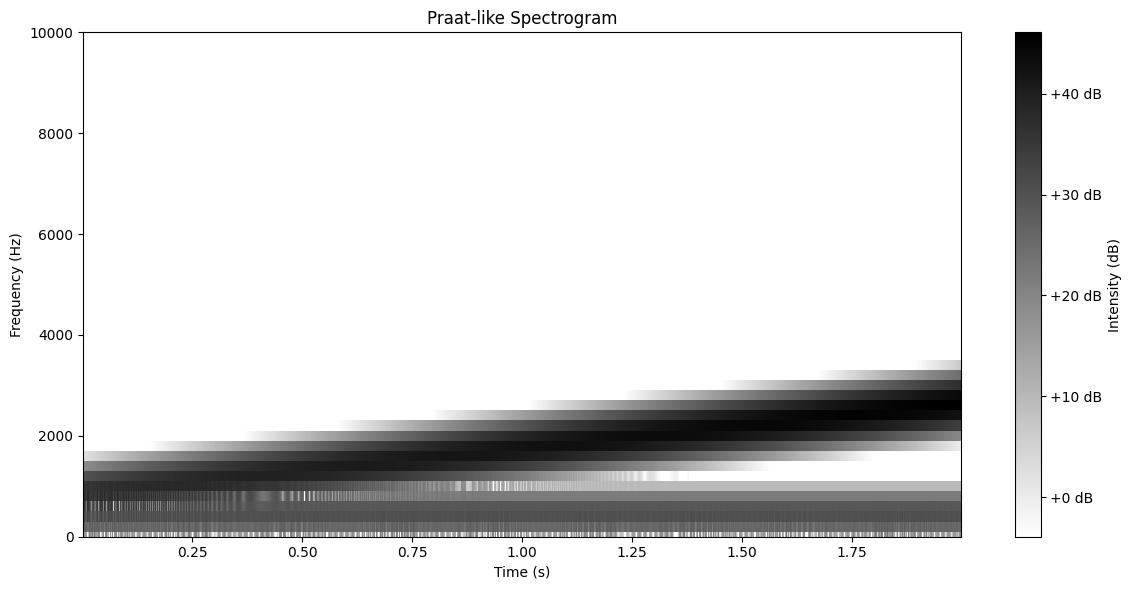

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram as scipy_spectrogram, windows

def praat_spectrogram(
    audio_path,
    output_path=None,
    view_range=(0, 10000),
    dynamic_range=50,
    window_length=0.005,
    pre_emphasis_from=50
):
    """
    Generates and optionally saves a Praat-like spectrogram.

    Args:
        audio_path (str): Path to the WAV audio file.
        output_path (str, optional): Path to save the spectrogram image. If None, the plot is displayed. Defaults to None.
        view_range (tuple, optional): The frequency range (min, max) to display in Hz. Defaults to (0, 10000).
        dynamic_range (int, optional): The dynamic range in dB for the colormap. Defaults to 50.
        window_length (float, optional): The length of the analysis window in seconds. Defaults to 0.005.
        pre_emphasis_from (int, optional): The frequency from which to apply pre-emphasis. Defaults to 50.
    """
    try:
        sample_rate, samples = wavfile.read(audio_path)

        # Ensure the audio is mono
        if samples.ndim > 1:
            samples = samples.mean(axis=1)

        # Pre-emphasis
        pre_emphasis_coeff = np.exp(-2 * np.pi * pre_emphasis_from / sample_rate)
        emphasized_samples = np.append(samples[0], samples[1:] - pre_emphasis_coeff * samples[:-1])

        nperseg = int(window_length * sample_rate)
        noverlap = int(nperseg * 0.75)  # 75% overlap

        # Using a Gaussian window as is common in Praat
        window = windows.gaussian(nperseg, std=nperseg / 8)

        # Calculate the spectrogram
        frequencies, times, Sxx = scipy_spectrogram(
            emphasized_samples,
            fs=sample_rate,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            scaling='density'
        )

        # Convert to dB, handling zero values
        Sxx_db = 10 * np.log10(np.maximum(Sxx, 1e-10))

        # Set the dynamic range
        max_db = np.max(Sxx_db)
        min_db = max_db - dynamic_range

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.pcolormesh(times, frequencies, Sxx_db, cmap='gray_r', vmin=min_db, vmax=max_db)

        plt.ylim(view_range)
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Praat-like Spectrogram")

        cbar = plt.colorbar(format='%+2.0f dB')
        cbar.set_label('Intensity (dB)')

        plt.tight_layout()

        if output_path:
            plt.savefig(output_path)
            print(f"Spectrogram saved to {output_path}")
        else:
            plt.show()

    except FileNotFoundError:
        print(f"Error: The file at {audio_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# --- Example Usage ---
# Create a dummy WAV file for demonstration
from scipy.io.wavfile import write
import numpy as np

sample_rate = 44100
duration = 2
frequency1 = 440
frequency2 = 880
t = np.linspace(0., duration, int(sample_rate * duration))
amplitude = np.iinfo(np.int16).max * 0.5
data = amplitude * (np.sin(2. * np.pi * frequency1 * t) + np.sin(2. * np.pi * frequency2 * t * (1 + t/duration)))
write("example.wav", sample_rate, data.astype(np.int16))


# Generate a spectrogram of the example audio
praat_spectrogram("example.wav", output_path="praat_like_spectrogram.png")

# To display the spectrogram instead of saving:
# praat_spectrogram("example.wav")